<a href="https://colab.research.google.com/github/RashmiGohil/Scaler-projects/blob/main/AdEaseTimeSeries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

AdEase aims to predict future Wikipedia page views to strategically place ads for clients across various regions and languages. By analyzing historical view data of 145,000 Wikipedia pages over 550 days, the goal is to forecast future views, enabling optimized ad placements tailored to specific languages and regions.

In [2]:
#Exploratory data analysis
#Data Structure & Characteristics:
#train_1.csv: Contains daily page views for each Wikipedia page over 550 days. Each row represents a page, and each column represents a day.
#Exog_Campaign_eng.csv: Contains binary indicators (1 or 0) for dates with significant events or campaigns affecting English Wikipedia pages.
#1.Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics

from sklearn.metrics import mean_absolute_percentage_error


In [3]:
#2. Data Loading and Reprocessing
# Load the training data
from google.colab import files
import pandas as pd
import re
uploaded= files.upload()

Saving Exog_Campaign_eng.txt to Exog_Campaign_eng.txt
Saving train_1.csv to train_1.csv


In [4]:
import pandas as pd
train_df = pd.read_csv('train_1.csv')

In [5]:
exog_campaign = pd.read_csv('Exog_Campaign_eng.txt')

In [6]:
# Fill missing values with 0
train_df.fillna(0, inplace=True)

# Extract components from the 'Page' column
def extract_page_components(page):
    match = re.match(r'(.+)_(\w+)\.wikipedia\.org_(\w+)_(\w+)', page)
    if match:
        return match.groups()
    else:
        return (None, None, None, None)

train_df[['Title', 'Language', 'Access_Type', 'Access_Origin']] = train_df['Page'].apply(lambda x: pd.Series(extract_page_components(x)))

# Load the exogenous campaign data for English pages
exog_campaign = pd.read_csv('Exog_Campaign_eng.txt')

# Fill missing values with 0
train_df.fillna(0, inplace=True)

# Extract components from the 'Page' column
def extract_page_components(page):
    match = re.match(r'(.+)_(\w+)\.wikipedia\.org_(\w+)_(\w+)', page)
    if match:
        return match.groups()
    else:
        return (None, None, None, None)

train_df[['Title', 'Language', 'Access_Type', 'Access_Origin']] = train_df['Page'].apply(lambda x: pd.Series(extract_page_components(x)))

# Load the exogenous campaign data for English pages
exog_campaign = pd.read_csv('Exog_Campaign_eng.txt')

# Fill missing values with 0
train_df.fillna(0, inplace=True)


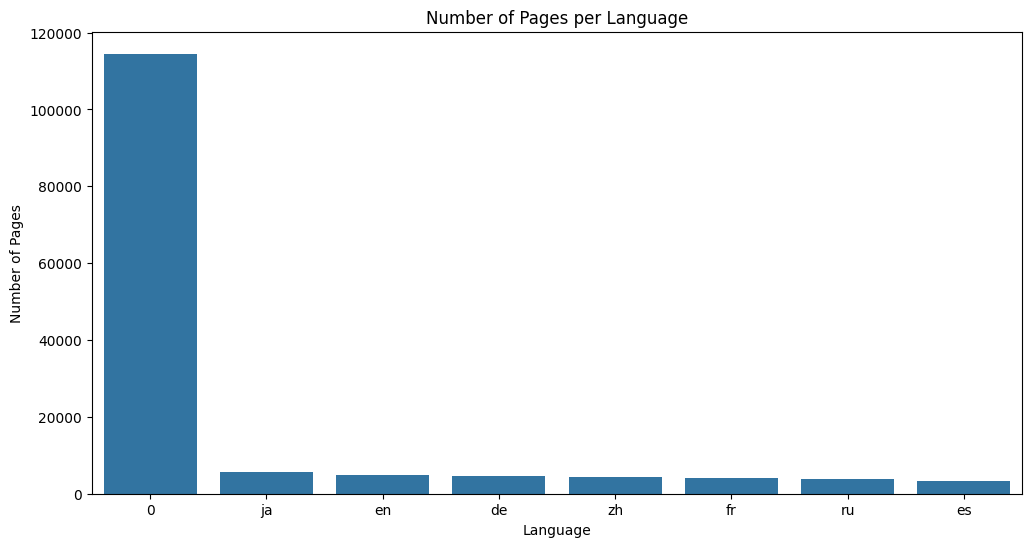

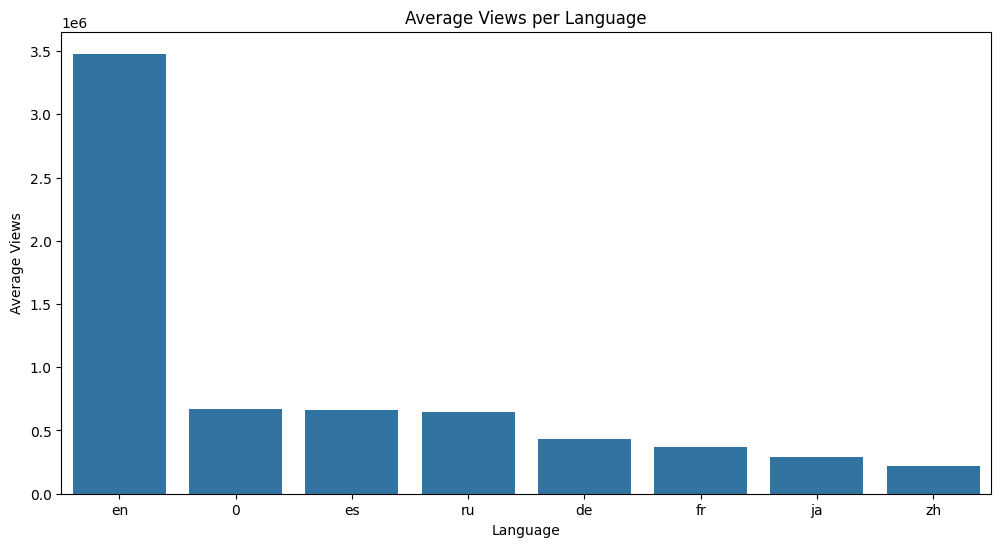

In [7]:
#3.Exploratory data analysis
# Number of pages per language
language_counts = train_df['Language'].value_counts()
plt.figure(figsize=(12,6))
sns.barplot(x=language_counts.index, y=language_counts.values)
plt.title('Number of Pages per Language')
plt.xlabel('Language')
plt.ylabel('Number of Pages')
plt.show()

# Average views per language
date_cols = train_df.columns[1:-4]  # Exclude 'Page' and the newly added columns
train_df['Total_Views'] = train_df[date_cols].sum(axis=1)
avg_views_language = train_df.groupby('Language')['Total_Views'].mean().sort_values(ascending=False)
plt.figure(figsize=(12,6))
sns.barplot(x=avg_views_language.index, y=avg_views_language.values)
plt.title('Average Views per Language')
plt.xlabel('Language')
plt.ylabel('Average Views')
plt.show()

Analyzing page: !vote


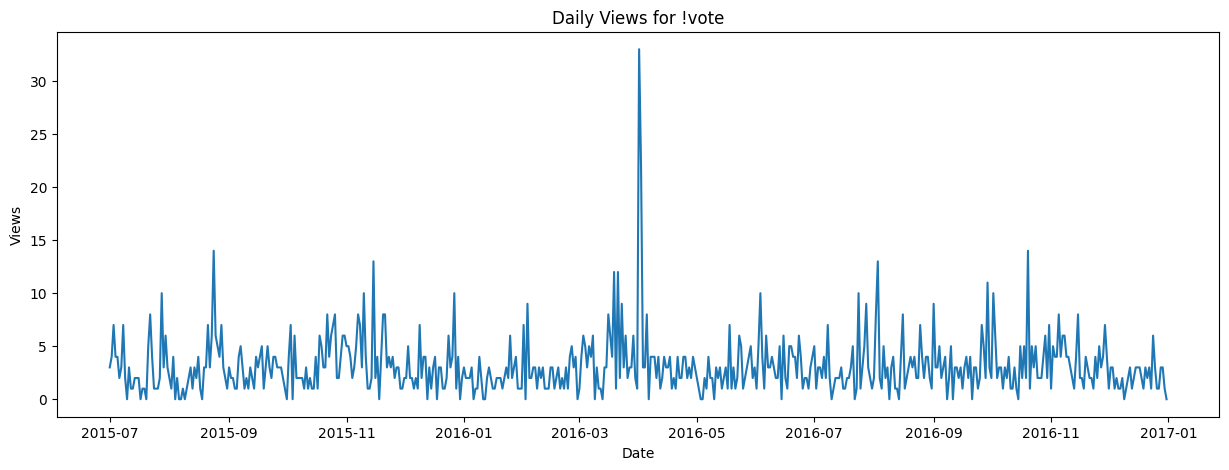

In [9]:
#4. Time series analysis for a sample page
# Filter English pages
# Filter English pages
english_pages = train_df[train_df['Language'] == 'en']

# Select a sample page
sample_page = english_pages.iloc[0]
page_title = sample_page['Title']
print(f"Analyzing page: {page_title}")

# Create time series
# Select the date columns and transpose the row into a Series
ts = sample_page[date_cols].T
# Convert the index to datetime objects
ts.index = pd.to_datetime(ts.index)
# The Series created by transposition doesn't have column names in the traditional sense.
# The values are the views. We just need to ensure they are float type.
ts = ts.astype(float)

# Plot the time series
plt.figure(figsize=(15,5))
plt.plot(ts) # Plot the Series directly
plt.title(f'Daily Views for {page_title}')
plt.xlabel('Date')
plt.ylabel('Views')
plt.show()

In [11]:
#5.Stationary Check
# Augmented Dickey-Fuller test
# Pass the time series Series directly to adfuller
result = adfuller(ts)
print('ADF Statistic:', result[0])
print('p-value:', result[1])
for key, value in result[4].items():
    print(f'Critical Value ({key}): {value}')

ADF Statistic: -9.232464065591687
p-value: 1.6641234739253205e-15
Critical Value (1%): -3.442383534871275
Critical Value (5%): -2.8668480382580386
Critical Value (10%): -2.569597004924258


ADF Statistic (Differenced): -11.659616200126749
p-value: 1.9475907523574807e-21


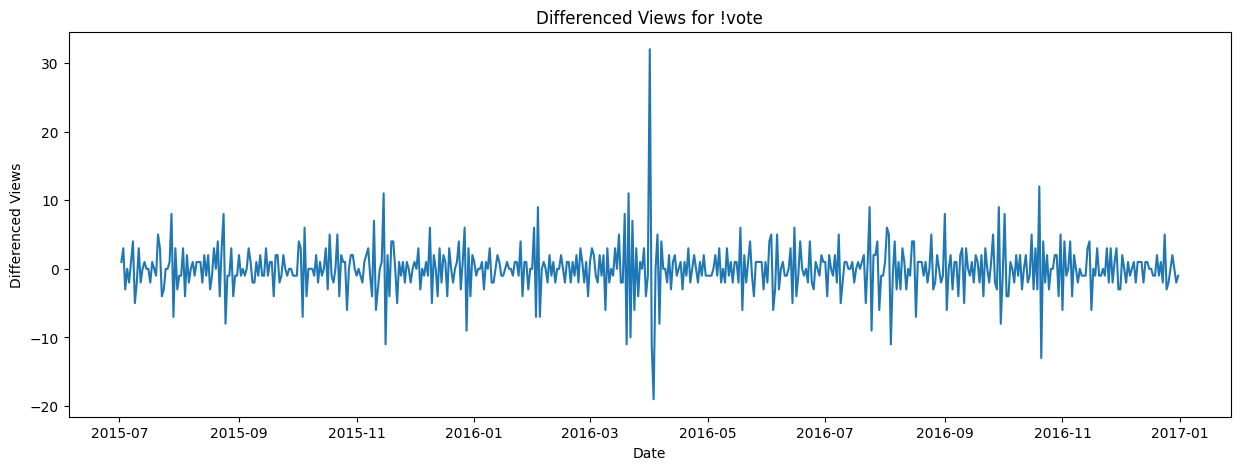

In [13]:
#6. Differencing to achieve Stationarity
# First-order differencing
ts_diff = ts.diff().dropna()

# ADF test on differenced series
result_diff = adfuller(ts_diff)
print('ADF Statistic (Differenced):', result_diff[0])
print('p-value:', result_diff[1])

# Plot differenced series
plt.figure(figsize=(15,5))
plt.plot(ts_diff)
plt.title(f'Differenced Views for {page_title}')
plt.xlabel('Date')
plt.ylabel('Differenced Views')
plt.show()


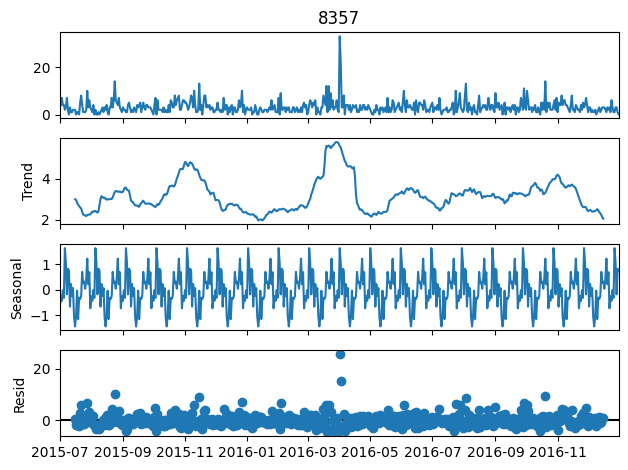

In [15]:
#&. Decomposition
decomposition = seasonal_decompose(ts, model='additive', period=30)
decomposition.plot()
plt.show()


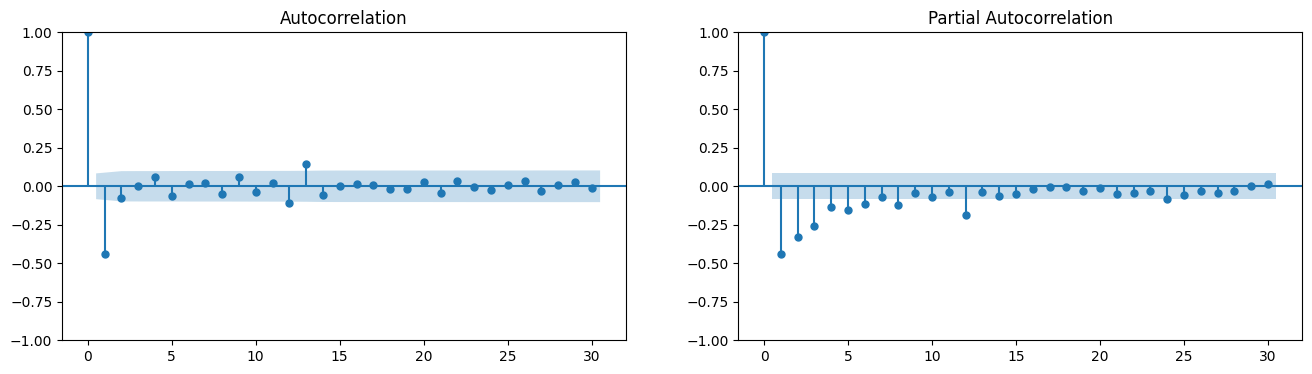

In [16]:
#8. ACF and PACF Plots
fig, ax = plt.subplots(1,2, figsize=(16,4))
plot_acf(ts_diff, lags=30, ax=ax[0])
plot_pacf(ts_diff, lags=30, ax=ax[1])
plt.show()


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                   8357   No. Observations:                  550
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1331.305
Date:                Mon, 02 Jun 2025   AIC                           2668.610
Time:                        11:55:59   BIC                           2681.535
Sample:                    07-01-2015   HQIC                          2673.661
                         - 12-31-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1411      0.025      5.761      0.000       0.093       0.189
ma.L1         -0.9552      0.014    -67.725      0.000      -0.983      -0.928
sigma2         7.4492      0.147     50.770      0.0

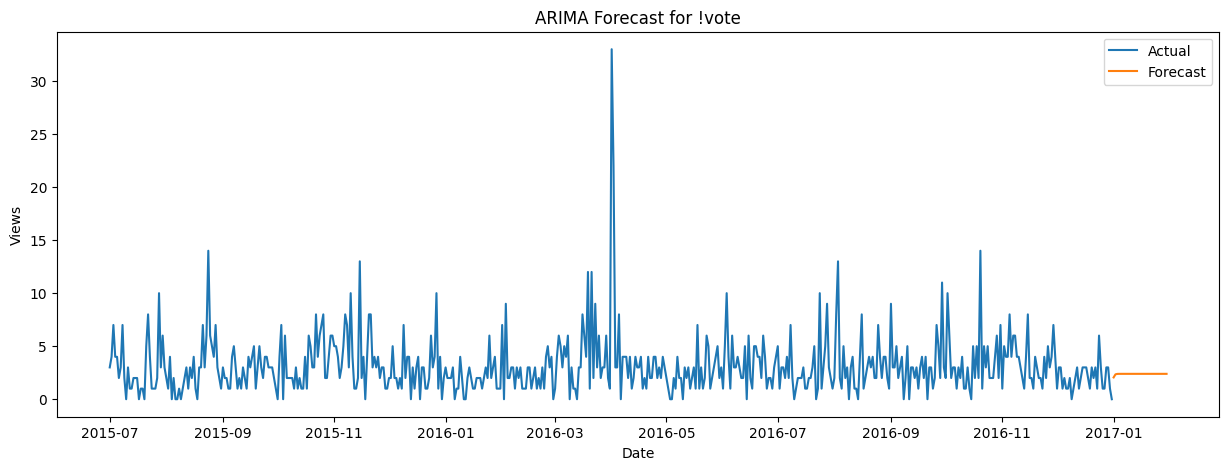

In [17]:
#8. ARIMA Modelling
# Fit ARIMA model
arima_model = ARIMA(ts, order=(1,1,1))
arima_result = arima_model.fit()
print(arima_result.summary())

# Forecast
forecast_steps = 30
arima_forecast = arima_result.forecast(steps=forecast_steps)

# Plot forecast
plt.figure(figsize=(15,5))
plt.plot(ts, label='Actual')
plt.plot(pd.date_range(ts.index[-1], periods=forecast_steps+1, freq='D')[1:], arima_forecast, label='Forecast')
plt.title(f'ARIMA Forecast for {page_title}')
plt.xlabel('Date')
plt.ylabel('Views')
plt.legend()
plt.show()


In [27]:
#10. SARIMAX Modelling with exogenous variables
# Prepare exogenous variable
exog_campaign['Date'] = pd.to_datetime(exog_campaign['Date'])
exog_campaign.set_index('Date', inplace=True)
exog_campaign = exog_campaign.reindex(ts.index).fillna(0)

# Fit SARIMAX model
sarimax_model = SARIMAX(ts['Views'], order=(1,1,1), seasonal_order=(1,1,1,7), exog=exog_campaign)
sarimax_result = sarimax_model.fit()
print(sarimax_result.summary())

# Forecast
sarimax_forecast = sarimax_result.forecast(steps=forecast_steps, exog=exog_campaign[-forecast_steps:])

# Plot forecast
plt.figure(figsize=(15,5))
plt.plot(ts['Views'], label='Actual')
plt.plot(pd.date_range(ts.index[-1], periods=forecast_steps+1, freq='D')[1:], sarimax_forecast, label='Forecast')
plt.title(f'SARIMAX Forecast for {page_title}')
plt.xlabel('Date')
plt.ylabel('Views')
plt.legend()
plt.show()


KeyError: 'Date'

In [23]:
#11. Facebook prophet modelling


KeyError: 'Campaign'

In [25]:
#12. Model evaluation(MAPE)
# Example actual values (replace with actual data)
actual_values = ts[-forecast_steps:]

# ARIMA MAPE
arima_mape = mean_absolute_percentage_error(actual_values, arima_forecast[:forecast_steps])
print(f'ARIMA MAPE: {arima_mape:.2%}')

# SARIMAX MAPE
sarimax_mape = mean_absolute_percentage_error(actual_values, sarimax_forecast[:forecast_steps])
print(f'SARIMAX MAPE: {sarimax_mape:.2%}')

# Prophet MAPE
prophet_forecast = forecast.set_index('ds')['yhat'][-forecast_steps:]
prophet_mape = mean_absolute_percentage_error(actual_values, prophet_forecast)
print(f'Prophet MAPE: {prophet_mape:.2%}')


ARIMA MAPE: 71841905283204216.00%


NameError: name 'sarimax_forecast' is not defined

#Insights and Recommentations:
1. Language-Specific Trends:

English pages show significant variability due to external events.

Non-English pages may have more stable trends, requiring different modeling approaches.

2. Impact of Campaigns:

Incorporating campaign data improves forecast accuracy for English pages.

Similar exogenous variables should be identified for other languages.

3. Model Selection:

No single model fits all scenarios; model choice should be based on data characteristics.

Prophet is advantageous for data with strong seasonality and known holidays.